In [1]:
import sys
from pathlib import Path

import parc
import matplotlib.pyplot as plt
import matplotlib.pylab as pl
import matplotlib
from matplotlib.colors import ListedColormap
import numpy as np
import pandas as pd
import umap
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.colors import LogNorm
from skimage import measure
from sklearn.decomposition import PCA
import seaborn as sns
import scipy.cluster.hierarchy as sch
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from collections import defaultdict
from skimage import exposure
import pickle

In [2]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [3]:
# Import path for config
module_path = str(Path.cwd().parents[0])
if module_path not in sys.path:
    sys.path.append(module_path)

# Import path for src
module_path = str(Path.cwd().parents[0] / "src")

if module_path not in sys.path:
    sys.path.append(module_path)

In [4]:
from config import *
import my_io as io

In [5]:
np.random.seed(0)
tol=0.4

# Import metadata information

In [6]:
df_metadata = pd.read_csv(data_dir / 'metadata.csv')
df_metadata.head()

,Pos,Grades,Stage,Directory
0,B1,2,I,Y:\coskun-lab\Thomas\Lung IMC\data\ROI\ROI001_B1
1,B3,2,I,Y:\coskun-lab\Thomas\Lung IMC\data\ROI\ROI005_B3
2,B5,2,II,Y:\coskun-lab\Thomas\Lung IMC\data\ROI\ROI006_B5
3,C6,AT,AT,Y:\coskun-lab\Thomas\Lung IMC\data\ROI\ROI007_C6
4,D7,3,IIIA,Y:\coskun-lab\Thomas\Lung IMC\data\ROI\ROI008_D7


In [7]:
datasets = df_metadata.Directory.to_list()
datasets = [name.split('\\')[-1] for name in datasets]

Read all the images and corresponding cell expression level

In [8]:
def get_cell_expression_level_mean(marker2img_dict, mask):    
    # Multiple each cell region by mean intensity 
    df_list = []
    for marker, img in marker2img_dict.items():
#         if marker not in ['DNA1', 'DNA2', 'Histone3', 'MHCII']:
        if marker in ['ECadherin','PanKeratin','CD68','CD8a', 'CD4', 'FoxP3','Col1', 'SMA']:
            # Contrast stretching
            p2, p98 = np.percentile(img, (0, 99.9))
            img_rescale = exposure.rescale_intensity(img, in_range=(p2, p98))
            exp_prop = pd.DataFrame(measure.regionprops_table(mask, img_rescale, properties=['label','mean_intensity'])).set_index('label')

            df = exp_prop.rename(columns = {'mean_intensity': marker}, errors = 'raise')
            df_list.append(df)
    df_exp = pd.concat(df_list, axis=1)
    return df_exp 

def get_cell_expression_level(marker2img_dict, mask):
    # Get each cell region 
    morph_prop = pd.DataFrame(measure.regionprops_table(mask, properties=['label', 'area'])).set_index('label')
    
    # Multiple each cell region by mean intensity 
    df_list = []
    for marker, img in marker2img_dict.items():
        if marker not in ['DNA1', 'DNA2', 'Histone3', 'MHCII', 'H3K9me3']:
            exp_prop = pd.DataFrame(measure.regionprops_table(mask, img, properties=['label','mean_intensity'])).set_index('label')
            df = pd.DataFrame(morph_prop.values * exp_prop.values, index=morph_prop.index, columns=[marker])
            df_list.append(df)
        
    df_exp = pd.concat(df_list, axis=1)
    return df_exp 

In [9]:
df_all = []
for dataset in datasets:
    print(f'Working on {dataset}')
    
    # Read images and corresponding marker names 
    imgs, markers = io.read_img(dataset, data_ROI)
    marker2img = dict(zip(markers, imgs))
    
    # Read corresponding mask
    mask = io.read_cell_mask(dataset, data_ROI)
    df_exp = get_cell_expression_level_mean(marker2img, mask)
#     x_scaled = StandardScaler().fit_transform(df_exp.T)
#     df_exp = pd.DataFrame(x_scaled.T, index = df_exp.index, columns=df_exp.columns)
#     x_scaled = StandardScaler().fit_transform(df_exp)
#     df_exp = pd.DataFrame(x_scaled, index = df_exp.index, columns=df_exp.columns)
    df_all.append(df_exp)
    
df = pd.concat(df_all, keys=datasets,  names=['ROI', 'cell_id'])
df.head()

Working on ROI001_B1
Working on ROI005_B3
Working on ROI006_B5
Working on ROI007_C6
Working on ROI008_D7
Working on ROI009_D9
Working on ROI012_E1
Working on ROI015_B6
Working on ROI016_F3
Working on ROI017_F2
Working on ROI018_G1
Working on ROI019_G5
Working on ROI020_E5
Working on ROI021_E7


SMA  PanKeratin      FoxP3        CD4  ECadherin  \
ROI       cell_id                                                           
ROI001_B1 1        13.852113   30.887324  16.929577  10.683099  71.394366   
          2        19.886792   14.698113  28.018868  38.490566  54.150943   
          3        34.481865  143.642487  29.797927  29.051813  95.792746   
          4        19.422857   88.074286  19.137143  13.920000  93.291429   
          5        34.745455   79.018182  34.545455  60.472727  98.818182   

                         CD68       CD8a       Col1  
ROI       cell_id                                    
ROI001_B1 1         13.211268  17.795775   4.774648  
          2         39.924528   2.716981   5.396226  
          3         25.129534  33.321244   9.036269  
          4          6.520000  20.760000   5.154286  
          5        129.145455  50.400000  29.000000

In [10]:
len(df)

44379

In [11]:
len(df.columns)

8

In [12]:
scaler = StandardScaler()
x_scaled = scaler.fit_transform(np.log(df+0.1))
x_scaled = scaler.fit_transform(x_scaled.T).T
df_exp = pd.DataFrame(
    x_scaled, index=df.index, columns=df.columns
)

Normalize dataset 

In [13]:
# x_scaled = StandardScaler().fit_transform(df)
# df_exp = pd.DataFrame(x_scaled, index = df.index, columns=df.columns)
# df_exp.head()

# # df_exp = df

In [14]:
df_exp

SMA  PanKeratin     FoxP3       CD4  ECadherin  \
ROI       cell_id                                                        
ROI001_B1 1        0.104005    0.483398 -0.314160 -0.652326   1.646331   
          2        0.427101   -0.682377  0.515057  1.055630   0.533549   
          3        0.181077    1.761954 -0.398411 -0.233412   0.702620   
          4        0.184784    1.508238 -0.313400 -0.401926   1.278204   
          5       -0.697100    0.159891 -1.163411  0.434990   0.204773   
...                     ...         ...       ...       ...        ...   
ROI021_E7 3496     0.927732   -0.395708 -1.175815 -0.410867   1.698703   
          3497     0.573201    1.626564  0.473042 -0.063101  -0.054086   
          3498     0.327276    0.190288  1.558639 -0.872809  -0.788609   
          3499     0.946044   -0.348811 -2.095549  0.147821   0.088069   
          3500     0.212322    0.316681 -2.113571  0.567141   1.451213   

                       CD68      CD8a      Col1  
ROI       cell_id                                
ROI001_B1 1       -0.006104  0.734272 -1.995416  
          2        1.078347 -1.810235 -1.117072  
          3       -0.392904  0.348800 -1.969723  
          4       -1.095534  0.400656 -1.561021  
          5        1.883225  0.593588 -1.415955  
...                     ...       ...       ...  
ROI021_E7 3496    -1.262851  0.925654 -0.306849  
          3497    -2.073649  0.194266 -0.676236  
          3498    -1.543926  1.279566 -0.150425  
          3499     0.035598 -0.337527  1.564355  
          3500    -0.916871  0.276480  0.206605  

[44379 rows x 8 columns]

Group by ROI

In [15]:
df_per_roi = df_exp.groupby('ROI').mean()
df_per_roi

,SMA,PanKeratin,FoxP3,CD4,ECadherin,CD68,CD8a,Col1
ROI,,,,,,,,
ROI001_B1,0.349015,0.543802,-0.152081,-0.691844,1.168583,-0.663081,0.490971,-1.045365
ROI005_B3,0.427993,-0.154478,-0.413648,-0.348516,0.416481,0.336362,-0.465309,0.201114
ROI006_B5,-1.158144,0.834642,0.726286,0.270512,0.116648,-0.378087,-0.011855,-0.400002
ROI007_C6,-0.824478,-0.003959,0.234471,0.725957,-0.266658,0.318894,-0.180654,-0.003573
ROI008_D7,-0.129535,-0.274231,0.057496,0.111710,0.340415,0.480005,-0.687613,0.101753
ROI009_D9,-0.423137,0.604516,0.343539,-0.034963,0.376693,0.166906,-0.162484,-0.871070
ROI012_E1,-0.162893,-0.684569,0.372388,0.414133,-0.511143,0.108809,0.283704,0.179571
ROI015_B6,-0.397726,0.026842,0.283901,0.255538,-0.615624,-0.397655,0.391367,0.453358
ROI016_F3,0.511638,-0.623101,-0.002273,-0.580040,-0.276521,0.299124,0.349605,0.321569


In [16]:
def create_HM(df_per_label, my_cmap, row_colors, scale_name, cellSizePixels=20, **kwargs):
    # Calulate the figure size, this gets us close, but not quite to the right place
    dpi = matplotlib.rcParams['figure.dpi']
    marginWidth = matplotlib.rcParams['figure.subplot.right']-matplotlib.rcParams['figure.subplot.left']
    marginHeight = matplotlib.rcParams['figure.subplot.top']-matplotlib.rcParams['figure.subplot.bottom']
    Ny,Nx = df_per_label.shape
    figWidth = (Nx*cellSizePixels/dpi)/marginWidth
    figHeigh = (Ny*cellSizePixels/dpi)/marginHeight
    
    ax = sns.clustermap(df_per_label,
                        cmap=my_cmap,
                        linewidth=0.5,
                        col_cluster=False,
                        row_cluster=False,
#                         row_colors=[row_colors],
                        dendrogram_ratio=(.1, 0.0),
                        figsize=(figWidth, figHeigh),
                        **kwargs
                        )
    ax.ax_heatmap.set_yticklabels(
        ax.ax_heatmap.get_yticklabels(), rotation=0)
    ax.ax_heatmap.set_xticklabels(
        ax.ax_heatmap.get_xticklabels(), rotation=45, horizontalalignment='right')
    ax.ax_heatmap.set_xlabel('Marker')
    ax.ax_heatmap.set_ylabel('ROI')
    
    # calculate the size of the heatmap axes
    axWidth = (Nx*cellSizePixels)/(figWidth*dpi)
    axHeight = (Ny*cellSizePixels)/(figHeigh*dpi)

    # resize heatmap
    ax_heatmap_orig_pos = ax.ax_heatmap.get_position()
    ax.ax_heatmap.set_position([ax_heatmap_orig_pos.x0, ax_heatmap_orig_pos.y0, 
                                  axWidth, axHeight])

    # resize dendrograms to match
#     ax_row_orig_pos = ax.ax_row_dendrogram.get_position()
#     ax.ax_row_dendrogram.set_position([ax_row_orig_pos.x0, ax_row_orig_pos.y0, 
#                                          ax_row_orig_pos.width, axHeight])
#     ax_row_orig_pos = ax.ax_row_colors.get_position()
#     ax.ax_row_colors.set_position([ax_row_orig_pos.x0, ax_row_orig_pos.y0, 
#                                          ax_row_orig_pos.width, axHeight])

    pos = ax.ax_heatmap.get_position()
    cbar_size=0.2
    ax.ax_cbar.set_position((1.1, pos.y0, .03, cbar_size))
    
    # Change colorbar label position
    cbar = ax.ax_heatmap.collections[0].colorbar
    cbar.set_label(scale_name, fontsize=12)

    for _, spine in ax.ax_heatmap.spines.items():
        spine.set_visible(True)
        spine.set_linewidth(3)

In [17]:
Grades = df_metadata.Grades.unique()

# Get random colormap
vals = np.linspace(0, 1, len(datasets))
my_cmap_row = plt.cm.tab20(vals)

# Change to row colors for clustermap
labels = df_metadata.Grades.to_list()
my_cmap_dict = dict(zip(labels, my_cmap_row))
row_colors = pd.DataFrame(labels)[0].map(my_cmap_dict)


In [18]:
df_per_roi.index = [roi[-2:] for roi in df_per_roi.index.tolist()]

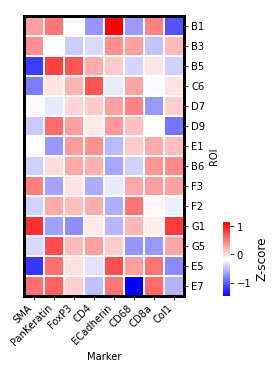

In [19]:
my_cmap_name = 'bwr'
scale_name = 'Z-score'

create_HM(df_per_roi, my_cmap_name, row_colors, scale_name)

In [20]:
# for dataset in datasets:
#     imgs, markers = io.read_img(dataset, data_ROI)
    
#     fig, axs = plt.subplots(2, 10, figsize=(25,6))
#     axs = axs.flatten()
#     for i, ax in enumerate(axs):
#         try:
#             ax.imshow(imgs[i], cmap='gray')
#             ax.set_title(markers[i])
#         except:
#             pass
#         ax.set_aspect('equal')
#         ax.axis('off')
#     fig.subplots_adjust(wspace=0.01, hspace=0.1)
#     fig.suptitle(dataset)
#     fig.savefig(data_figure / 'expression_level' / f'{dataset}.png', bbox_inches='tight', dpi=150)
#     plt.show()
    

# Clustering

In [21]:
X = df_exp.values
parc1 = parc.PARC(X, jac_weighted_edges = False, random_seed=0)
parc1.run_PARC() 
parc_labels = parc1.labels

graph = parc1.knngraph_full()
embeddings = parc1.run_umap_hnsw(X, graph, random_state = 1)

input data has shape 44379 (samples) x 8 (features)
knn struct was not available, so making one
commencing local pruning based on Euclidean distance metric at 3 s.dev above mean
commencing global pruning
commencing community detection
partition type MVP
list of cluster labels and populations 25 [(0, 3239), (1, 2987), (2, 2947), (3, 2857), (4, 2502), (5, 2464), (6, 2419), (7, 2370), (8, 2307), (9, 2136), (10, 2093), (11, 2057), (12, 1983), (13, 1912), (14, 1575), (15, 1428), (16, 1370), (17, 1181), (18, 988), (19, 939), (20, 809), (21, 598), (22, 527), (23, 463), (24, 228)]
time elapsed 25.6 seconds
a,b, spread, dist 1.5769434603935901 0.8950608781603765 1.0 0.1
	completed  0  /  200 epochs
	completed  20  /  200 epochs
	completed  40  /  200 epochs
	completed  60  /  200 epochs
	completed  80  /  200 epochs
	completed  100  /  200 epochs
	completed  120  /  200 epochs
	completed  140  /  200 epochs
	completed  160  /  200 epochs
	completed  180  /  200 epochs


In [22]:
with open(data_dir / f"clustering_all_cell_subset.pickle", "wb") as f:
    pickle.dump([parc_labels, embeddings, df_exp], f)

In [23]:
# with open(data_dir / f'clustering_all_cell.pickle', 'rb') as f:
#     parc_labels, embeddings, df = pickle.load(f)
    

Text(0, 0.5, 'Umap 2')

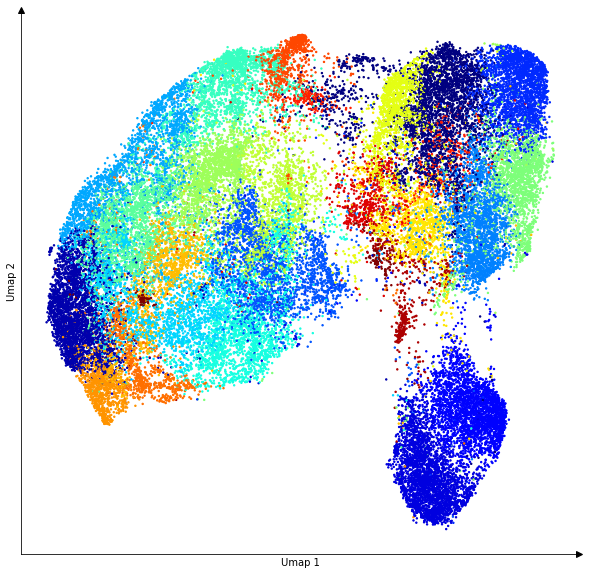

In [24]:
name = 'Umap'

fig, ax = plt.subplots(figsize=(10, 10))
X, Y = embeddings[:, 0], embeddings[:, 1]
ax.scatter(X, Y, c=parc_labels, s=2, cmap='jet')
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.tick_params(axis='both', which='both', bottom=False, left=False, labelbottom=False, labelleft=False)

# Add arrow with spine
pos = ax.get_position()
ax.plot(pos.x1, pos.y0, ">k", transform=fig.transFigure, clip_on=False)
ax.plot(pos.x0, pos.y1, "^k", transform=fig.transFigure, clip_on=False)

# Add label
ax.set_xlabel(f'{name} 1')
ax.set_ylabel(f'{name} 2')

In [25]:
mapping = {}
i = 0
for dataset in datasets:
    mapping[dataset] = i
    i += 1

dataset_num = np.array(list(map(mapping.get, df_exp.index.get_level_values(0))))

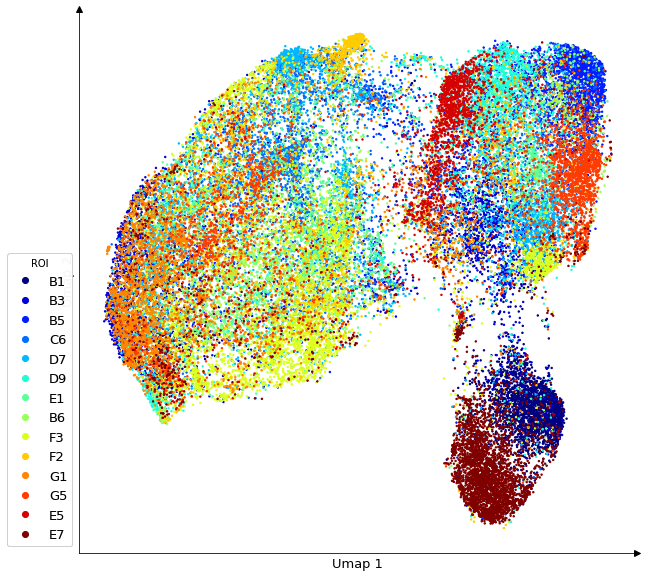

In [26]:
fig, ax = plt.subplots(figsize=(10, 10))
X, Y = embeddings[:, 0], embeddings[:, 1]
scatter = ax.scatter(X, Y, c=dataset_num, s=2, cmap='jet')
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.tick_params(axis='both', which='both', bottom=False, left=False, labelbottom=False, labelleft=False)

# Add arrow with spine
pos = ax.get_position()
ax.plot(pos.x1, pos.y0, ">k", transform=fig.transFigure, clip_on=False)
ax.plot(pos.x0, pos.y1, "^k", transform=fig.transFigure, clip_on=False)

# Add label
ft = 13
ax.set_xlabel(f'{name} 1', fontsize=ft)
ax.set_ylabel(f'{name} 2', fontsize=ft)

labels = list(df_exp.index.get_level_values(0).unique())
legend1 = ax.legend(handles=scatter.legend_elements()[0], 
                    labels=[dataset[-2:] for dataset in labels],
                    bbox_to_anchor=(0, 0),
                    loc="lower right", 
                    title="ROI",
                   fontsize=ft)
ax.add_artist(legend1)

In [27]:
mapping_stage = {}
i = 0
for stage in df_metadata.Stage.unique():
    mapping_stage[stage] = i
    i += 1

dataset2num = df_metadata.Stage.map(mapping_stage.get).to_dict()
stage_num = np.array(list(map(dataset2num.get, dataset_num)))

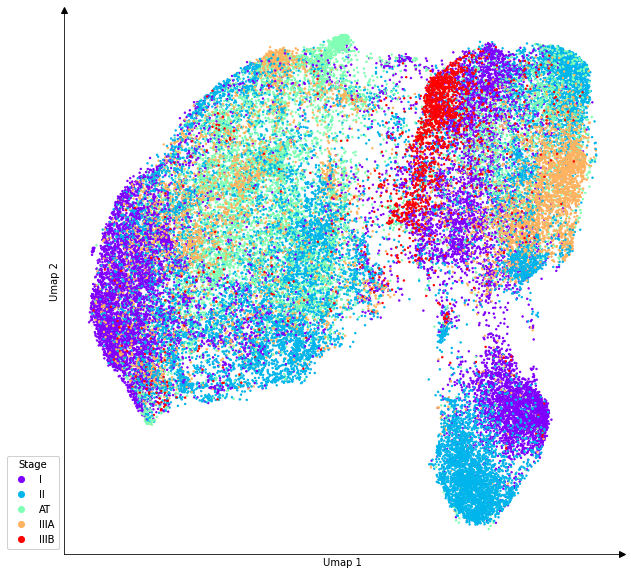

In [28]:
fig, ax = plt.subplots(figsize=(10, 10))
X, Y = embeddings[:, 0], embeddings[:, 1]
scatter = ax.scatter(X, Y, c=stage_num, s=2, cmap='rainbow')
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.tick_params(axis='both', which='both', bottom=False, left=False, labelbottom=False, labelleft=False)

# Add arrow with spine
pos = ax.get_position()
ax.plot(pos.x1, pos.y0, ">k", transform=fig.transFigure, clip_on=False)
ax.plot(pos.x0, pos.y1, "^k", transform=fig.transFigure, clip_on=False)

# Add label
ax.set_xlabel(f'{name} 1')
ax.set_ylabel(f'{name} 2')

legend1 = ax.legend(handles=scatter.legend_elements()[0], 
                    labels=list(mapping_stage.keys()),
                    bbox_to_anchor=(0, 0),
                    loc="lower right", 
                    title="Stage")
ax.add_artist(legend1)

In [29]:
mapping_grade = {}
i = 0
for grade in df_metadata.Grades.unique():
    mapping_grade[grade] = i
    i += 1

dataset2num = df_metadata.Grades.map(mapping_grade.get).to_dict()
grade_num = np.array(list(map(dataset2num.get, dataset_num)))

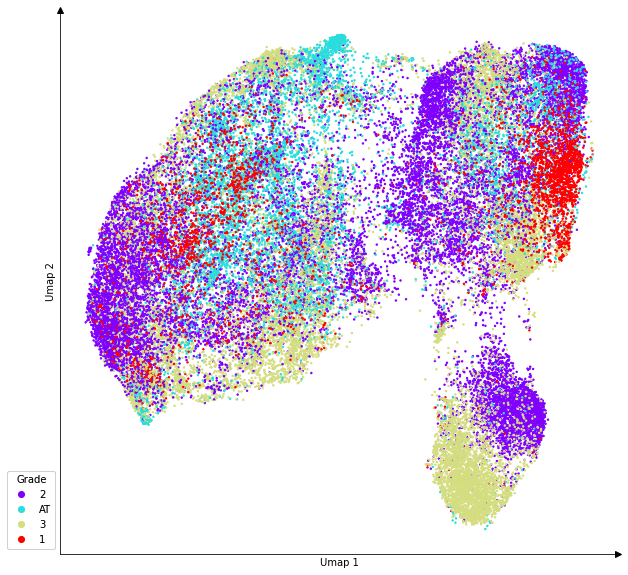

In [30]:
fig, ax = plt.subplots(figsize=(10, 10))
X, Y = embeddings[:, 0], embeddings[:, 1]
scatter = ax.scatter(X, Y, c=grade_num, s=2, cmap='rainbow')
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.tick_params(axis='both', which='both', bottom=False, left=False, labelbottom=False, labelleft=False)

# Add arrow with spine
pos = ax.get_position()
ax.plot(pos.x1, pos.y0, ">k", transform=fig.transFigure, clip_on=False)
ax.plot(pos.x0, pos.y1, "^k", transform=fig.transFigure, clip_on=False)

# Add label
ax.set_xlabel(f'{name} 1')
ax.set_ylabel(f'{name} 2')

legend1 = ax.legend(handles=scatter.legend_elements()[0], 
                    labels=list(mapping_grade.keys()),
                    bbox_to_anchor=(0, 0),
                    loc="lower right", 
                    title="Grade")
ax.add_artist(legend1)